# Проект по классификации изображений

Будем решать достаточно известную задачу классификации персонажей всем известного мультсериала :)








![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

##Загрузка данных

Данные можно скачать [ссылке](https://disk.yandex.ru/d/U9bpivZ-Tpknfw).



In [ ]:
!pip install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://disk.yandex.ru/d/U9bpivZ-Tpknfw) -o simspons.zip
!unzip -qq simspons.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  520M  100  520M    0     0  21.5M      0  0:00:24  0:00:24 --:--:-- 25.2M


Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from pathlib import Path
from torchvision import datasets, models, transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

import seaborn as sns

torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Даталоадер за вас уже написаны :)

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet

Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. Картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample).

In [ ]:
# разные режимы загрузки датасета
data_modes = ['train', 'val', 'test']

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)


    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

Читаем данные

In [ ]:
train_dir = Path('train/simpsons_dataset')
test_dir = Path('testset/testset')

train_val_files = list(train_dir.rglob('*.jpg'))
test_files = list(test_dir.rglob('*.jpg'))

Разделяем на выборки

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

Определим функции для отображения картинок и выведем 9 случайных из трейна

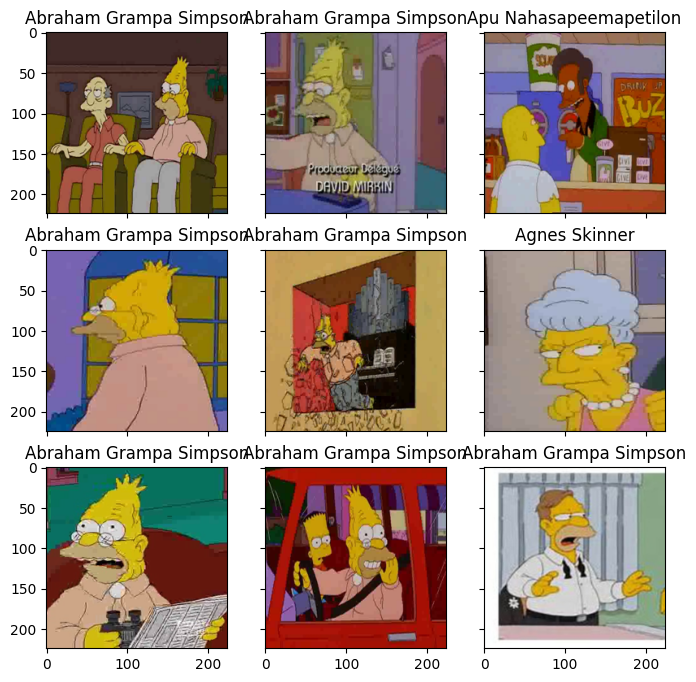

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt_ax.imshow(inp)
    plt_ax.set_title(title)


fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

Используйте все полученные знания (можно и выйти за рамки пройденного материала), чтобы добиться наилучшего качества модели на валидационном наборе данных (accuracy).
Минимальное требуемое значения метрики - 0.83. Постарайтесь получить 0.95+ ;)
На тесте сделайте визуальную проверку результатов.

Кроме построения нейросети и оценки её качества вам необходимо:
- замерять время обучения сети;
- написать функцию, которая на вход будет принимать ссылку на произвольное изображение и прогнозировать его класс;
- написать код, который будет выводть 9 случайных изображений из теста с их фактическими и прогнозными классами.

Изучите классы, на которых модель чаще всего ошибается, напишите финальные выводы и пути дальнейшего улучшения работы.

##Знакомство с данными, дисбаланс классов

In [ ]:
class_names = train_dataset.label_encoder.classes_
print(len(class_names))
print(class_names)

42
['abraham_grampa_simpson' 'agnes_skinner' 'apu_nahasapeemapetilon'
 'barney_gumble' 'bart_simpson' 'carl_carlson' 'charles_montgomery_burns'
 'chief_wiggum' 'cletus_spuckler' 'comic_book_guy' 'disco_stu'
 'edna_krabappel' 'fat_tony' 'gil' 'groundskeeper_willie' 'homer_simpson'
 'kent_brockman' 'krusty_the_clown' 'lenny_leonard' 'lionel_hutz'
 'lisa_simpson' 'maggie_simpson' 'marge_simpson' 'martin_prince'
 'mayor_quimby' 'milhouse_van_houten' 'miss_hoover' 'moe_szyslak'
 'ned_flanders' 'nelson_muntz' 'otto_mann' 'patty_bouvier'
 'principal_skinner' 'professor_john_frink' 'rainier_wolfcastle'
 'ralph_wiggum' 'selma_bouvier' 'sideshow_bob' 'sideshow_mel'
 'snake_jailbird' 'troy_mcclure' 'waylon_smithers']


Посмотрим на количество объектов в каждом классе тренировочной выборки

In [ ]:
len(train_files)

15699

In [ ]:
from collections import Counter

train_labels = [path.parent.name for path in train_files]
train_counter = Counter(train_labels)

print("Количество объектов в каждом классе тренировочной выборки:")
for class_name, count in train_counter.items():
    print(f"Класс {class_name}, количество {count}, доля {count * 100 / len(train_files):.2f}%")



Количество объектов в каждом классе тренировочной выборки:
Класс lisa_simpson, количество 1015, доля 6.47%
Класс apu_nahasapeemapetilon, количество 467, доля 2.97%
Класс moe_szyslak, количество 1089, доля 6.94%
Класс edna_krabappel, количество 343, доля 2.18%
Класс kent_brockman, количество 373, доля 2.38%
Класс chief_wiggum, количество 739, доля 4.71%
Класс principal_skinner, количество 895, доля 5.70%
Класс homer_simpson, количество 1684, доля 10.73%
Класс ned_flanders, количество 1090, доля 6.94%
Класс sideshow_bob, количество 658, доля 4.19%
Класс milhouse_van_houten, количество 809, доля 5.15%
Класс mayor_quimby, количество 185, доля 1.18%
Класс charles_montgomery_burns, количество 895, доля 5.70%
Класс ralph_wiggum, количество 67, доля 0.43%
Класс abraham_grampa_simpson, количество 685, доля 4.36%
Класс marge_simpson, количество 968, доля 6.17%
Класс maggie_simpson, количество 96, доля 0.61%
Класс krusty_the_clown, количество 904, доля 5.76%
Класс comic_book_guy, количество 352, 

Видим явный дисбаланс классов, для борьбы с ним выделим миноритарные классы для последующего применения аугментации

###Борьба с дисбалансом: аугментация миноритарных классов

Подсчитаем среднее число объектов в классе для того, чтобы провести черту между миноритарными и мажоритарными классами

In [ ]:
mean_class_count = sum(train_counter.values()) / len(train_counter)
print(f"Среднее количество объектов в классе: {mean_class_count}")

Среднее количество объектов в классе: 373.7857142857143


Выделим миноритарные классы

In [ ]:
minority_class = [class_name for class_name, count in train_counter.items() if count < mean_class_count]
print(minority_class)

['edna_krabappel', 'kent_brockman', 'mayor_quimby', 'ralph_wiggum', 'maggie_simpson', 'comic_book_guy', 'rainier_wolfcastle', 'waylon_smithers', 'carl_carlson', 'selma_bouvier', 'gil', 'lenny_leonard', 'nelson_muntz', 'professor_john_frink', 'fat_tony', 'martin_prince', 'barney_gumble', 'cletus_spuckler', 'miss_hoover', 'patty_bouvier', 'agnes_skinner', 'groundskeeper_willie', 'disco_stu', 'snake_jailbird', 'sideshow_mel', 'otto_mann', 'troy_mcclure', 'lionel_hutz']


Переопределим класс SimsonsDataset с применением аугментации только к миноритарным классам тренировочной выорки

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    #Создаём метод для аугментаций
    def augment_image(self, x):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.TrivialAugmentWide(num_magnitude_bins=5),
            transforms.ToTensor()
        ])(x)

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            # Применяем аугментацию только к миноритарным классам
            if label in minority_class:
                x = self.augment_image(x)
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)


In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

###Борьба с дисбалансом: список весов

Создание списка весов и преобразование к тензору для передачи в функцию потерь кросс-энтропии

In [ ]:
class_frequency = {class_name: count / len(train_labels) for class_name, count in train_counter.items()}
class_weights = [1.0 / class_frequency[class_name] for class_name in train_counter.keys()]
weights = torch.tensor(class_weights, dtype=torch.float32)

###Разделение на батчи

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                             batch_size=32,
                             shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False)
train_loader, val_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7965448cbb80>,
 <torch.utils.data.dataloader.DataLoader at 0x7965448cbb20>)

Проверка батча

In [ ]:
img, label = next(iter(train_loader))
print(f"Размерность изображения: {img.shape} -> [размер батча, цветовые каналы, высота, ширина]")

Размерность изображения: torch.Size([32, 3, 224, 224]) -> [размер батча, цветовые каналы, высота, ширина]


##Transfer learning

###Создание функции обучения с замером времени и функции оценки

In [ ]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    model.to(device)
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Эпоха {epoch+1}')
        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn)
    end_time = time.time()
    train_time = end_time - start_time
    print(f"Время обучения: {train_time} секунд")
    return model, train_time
def evaluate(model, data_loader, loss_fn):
    total_loss = 0
    correct = 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            pred = torch.argmax(pred, dim=1)
            correct += torch.sum(pred == y).item()
    mean_loss = total_loss / len(data_loader)
    accuracy = correct / len(data_loader.dataset)

    print(f"Функция потерь (кросс-энтропия) на данных {mean_loss}")
    print(f"Точность на данных {accuracy}")

    return mean_loss, accuracy

Функция вывода матрицы ошибок

In [ ]:
def showmatrix(conf):
    df_conf = pd.DataFrame(conf,
                      index=class_names,
                      columns=class_names)
    plt.figure(figsize=(20, 16))
    sns.heatmap(df_conf, annot=True, cmap='Blues', fmt='g')
    plt.show()

###Загрузка предобученных моделей, замена выходного слоя

In [ ]:
weights_AlexNet= models.AlexNet_Weights.DEFAULT
model_AlexNet = models.alexnet(weights=weights_AlexNet)
model_AlexNet.classifier[6] = nn.Linear(4096, len(class_names))

weights_VGG19 = models.VGG19_Weights.DEFAULT
model_VGG19 = models.vgg19(weights=weights_VGG19)
model_VGG19.classifier[6] = nn.Linear(4096, len(class_names))

weights_ResNet = models.ResNet18_Weights.DEFAULT
model_ResNet = models.resnet18(weights=weights_ResNet)
model_ResNet.fc = nn.Linear(512, len(class_names))

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 155MB/s]  
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 165MB/s]  
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s] 


###Обучение предобученной модели на наших классах

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
weights = weights.to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)


####Модель AlexNet

In [ ]:
optimizer = torch.optim.Adam(model_AlexNet.parameters(), lr=1e-4)
model_AlexNet, train_time = train(model_AlexNet, train_loader, val_loader, loss_fn, optimizer, 15)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.9624215218795054
Точность на данных 0.4753534581581964
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.4400178278099303
Точность на данных 0.6058463889950325
Эпоха 3
Функция потерь (кросс-энтропия) на данных 1.2012539670185793
Точность на данных 0.7032862055789072
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.0764878758778558
Точность на данных 0.7090179594956056
Эпоха 5
Функция потерь (кросс-энтропия) на данных 1.034970296381067
Точность на данных 0.7265953381734811
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.0214638068274526
Точность на данных 0.7569736339319831
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.7827275793118074
Точность на данных 0.7965227359572029
Эпоха 8
Функция потерь (кросс-энтропия) на данных 1.3975185427556336
Точность на данных 0.6643102789453573
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.8816429484134157
Точность на данных 0.7821933511654566
Эпоха 10
Функция потерь (кросс-энтропи

In [ ]:
ALEXNET0 = MODEL_PATH / "alexnet_model_0.pth"
torch.save(obj=model_AlexNet.state_dict(),
           f=ALEXNET0)


####Модель VGG19

In [ ]:
optimizer = torch.optim.Adam(model_VGG19.parameters(), lr=1e-4)
model_VGG19, train_time = train(model_VGG19, train_loader, val_loader, loss_fn, optimizer, 15)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.834306555447877
Точность на данных 0.49484142147497134
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.5513686970552065
Точность на данных 0.554069545280856
Эпоха 3
Функция потерь (кросс-энтропия) на данных 2.2387314502651328
Точность на данных 0.4564386702330913
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.4358150070310907
Точность на данных 0.6287734046618265
Эпоха 5
Функция потерь (кросс-энтропия) на данных 1.2159654289016864
Точность на данных 0.7265953381734811
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.4005344367695924
Точность на данных 0.6826518914787925
Эпоха 7
Функция потерь (кросс-энтропия) на данных 1.184359900367697
Точность на данных 0.7302254489873902
Эпоха 8
Функция потерь (кросс-энтропия) на данных 1.2650004865722364
Точность на данных 0.6350783339701949
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.8953817392368226
Точность на данных 0.7688192586931601
Эпоха 10
Функция потерь (кросс-энтропия

In [ ]:
VGG190 = MODEL_PATH / "vgg19_model_0.pth"
torch.save(obj=model_VGG19.state_dict(),
           f=VGG190)


####Модель ResNet

In [ ]:
optimizer = torch.optim.Adam(model_ResNet.parameters(), lr=1e-4)
model_ResNet, train_time = train(model_ResNet, train_loader, val_loader, loss_fn, optimizer, 15)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.629800533833232
Точность на данных 0.5508215513947268
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.328697263753805
Точность на данных 0.6217042414978984
Эпоха 3
Функция потерь (кросс-энтропия) на данных 1.2275558794726527
Точность на данных 0.6702330913259458
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.814612694339558
Точность на данных 0.6329766908674054
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.9722202819982572
Точность на данных 0.7569736339319831
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.1558168450993551
Точность на данных 0.7044325563622469
Эпоха 7
Функция потерь (кросс-энтропия) на данных 1.189597846200674
Точность на данных 0.738440962934658
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.8787032834259869
Точность на данных 0.777034772640428
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.798509474241865
Точность на данных 0.784486052732136
Эпоха 10
Функция потерь (кросс-энтропия) на д

In [ ]:
RESNET = MODEL_PATH / "resnet_model_0.pth"
torch.save(obj=model_ResNet.state_dict(),
           f=RESNET)


In [ ]:
accuracy_AlexNet = round(evaluate(model_AlexNet, val_loader, loss_fn)[1],2)
accuracy_VGG19 = round(evaluate(model_VGG19, val_loader, loss_fn)[1],2)
accuracy_ResNet = round(evaluate(model_ResNet, val_loader, loss_fn)[1],2)

Функция потерь (кросс-энтропия) на данных 0.9705315023939409
Точность на данных 0.7812380588460068
Функция потерь (кросс-энтропия) на данных 0.9592159843158763
Точность на данных 0.7627053878486817
Функция потерь (кросс-энтропия) на данных 0.7303304740907431
Точность на данных 0.8194497516239969


In [ ]:
results = pd.DataFrame(columns=['model', 'accuracy', 'time'])

In [ ]:
AlexNet_results = {'model': 'AlexNet', 'accuracy': {accuracy_AlexNet}, 'time': '1752'}
results.loc[len(results)] = AlexNet_results
VGG19_results = {'model': 'VGG19', 'accuracy': {accuracy_VGG19}, 'time': '4994'}
results.loc[len(results)] = VGG19_results
ResNet_results = {'model': 'ResNet', 'accuracy': {accuracy_ResNet}, 'time': '1841'}
results.loc[len(results)] = ResNet_results

In [ ]:
print(results)

     model accuracy  time
0  AlexNet   {0.78}  1752
1    VGG19   {0.76}  4994
2   ResNet   {0.82}  1841


Построим матрицы ошибок для каждой модели

матрица для AlexNet

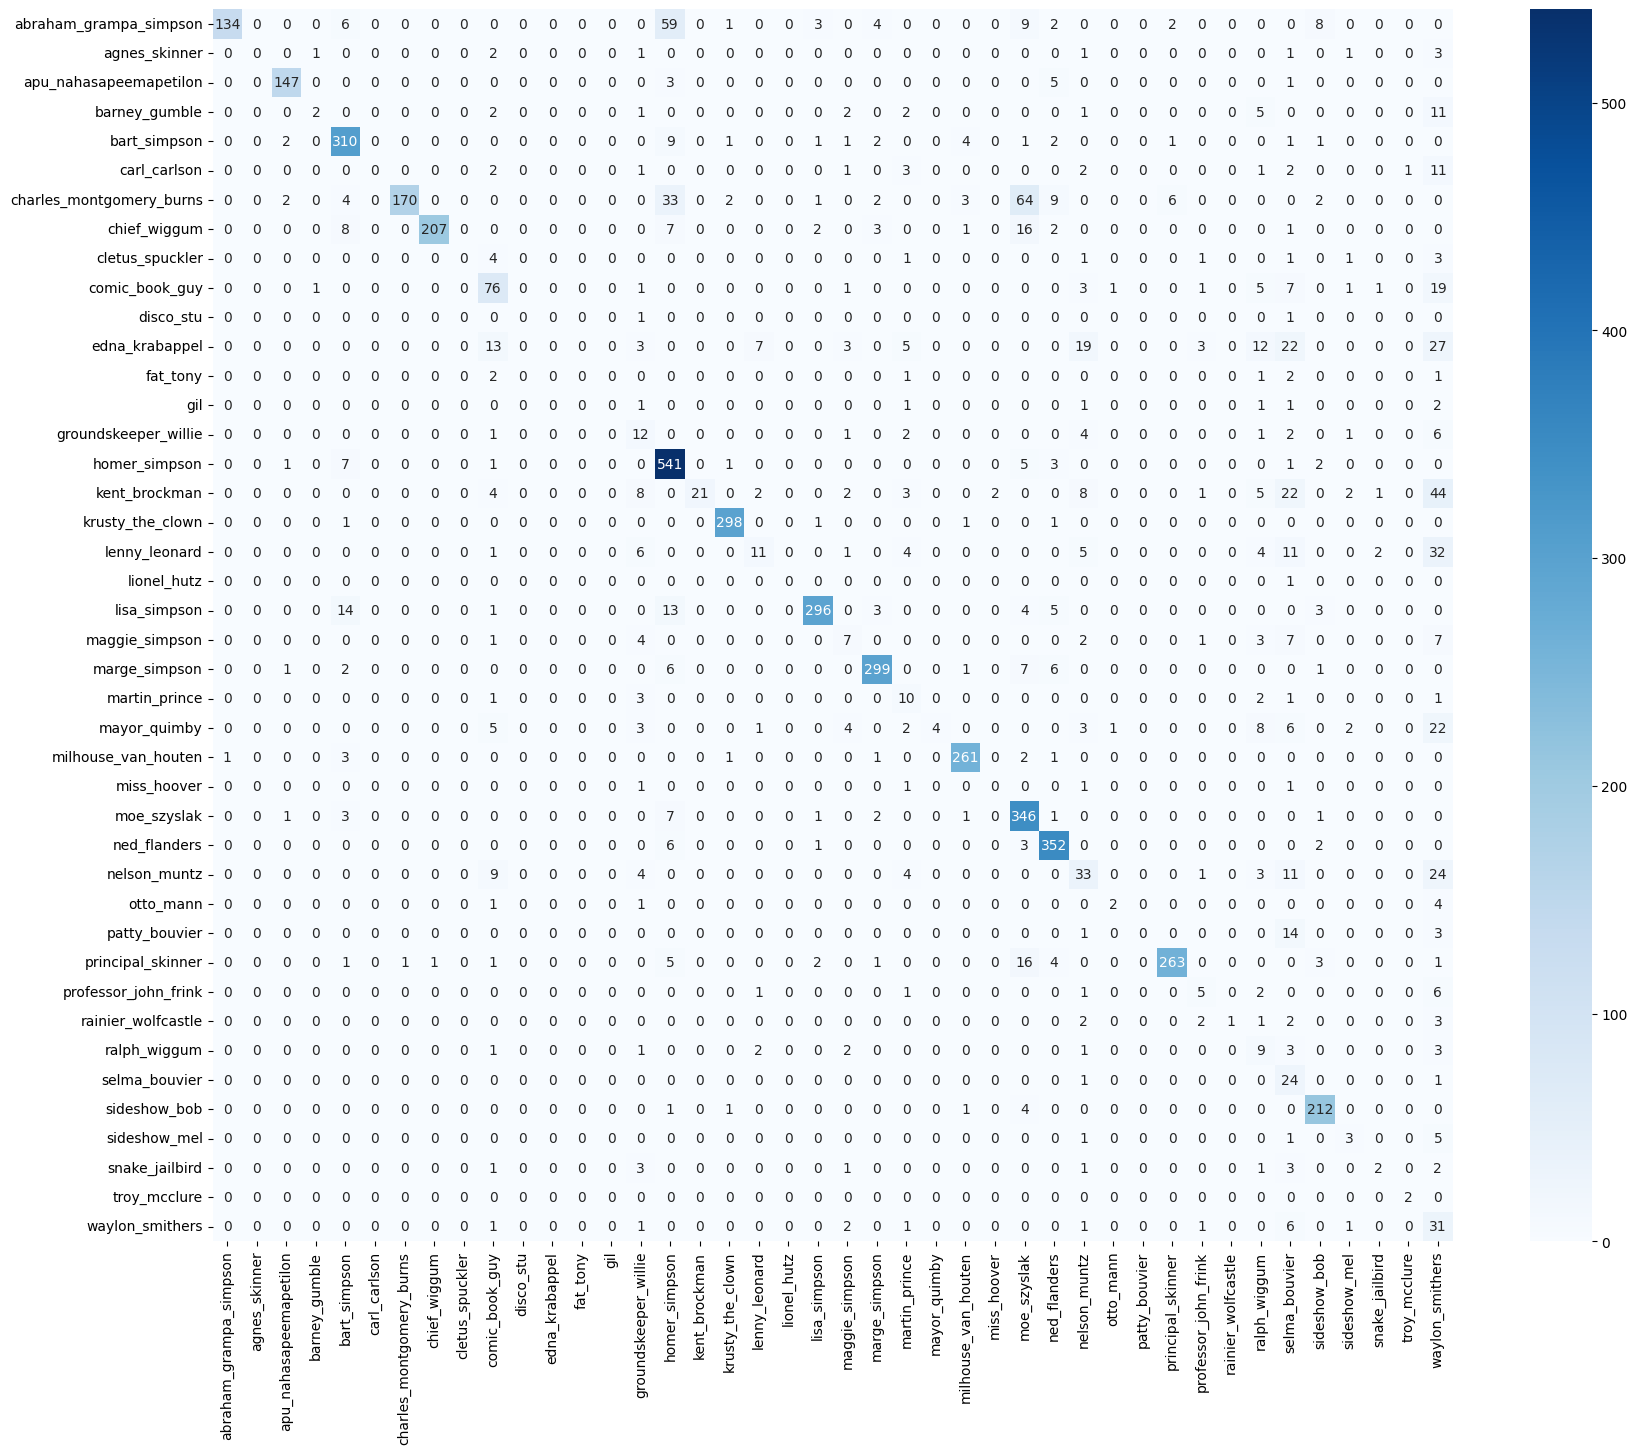

In [ ]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_AlexNet(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

Матрица для VGG19

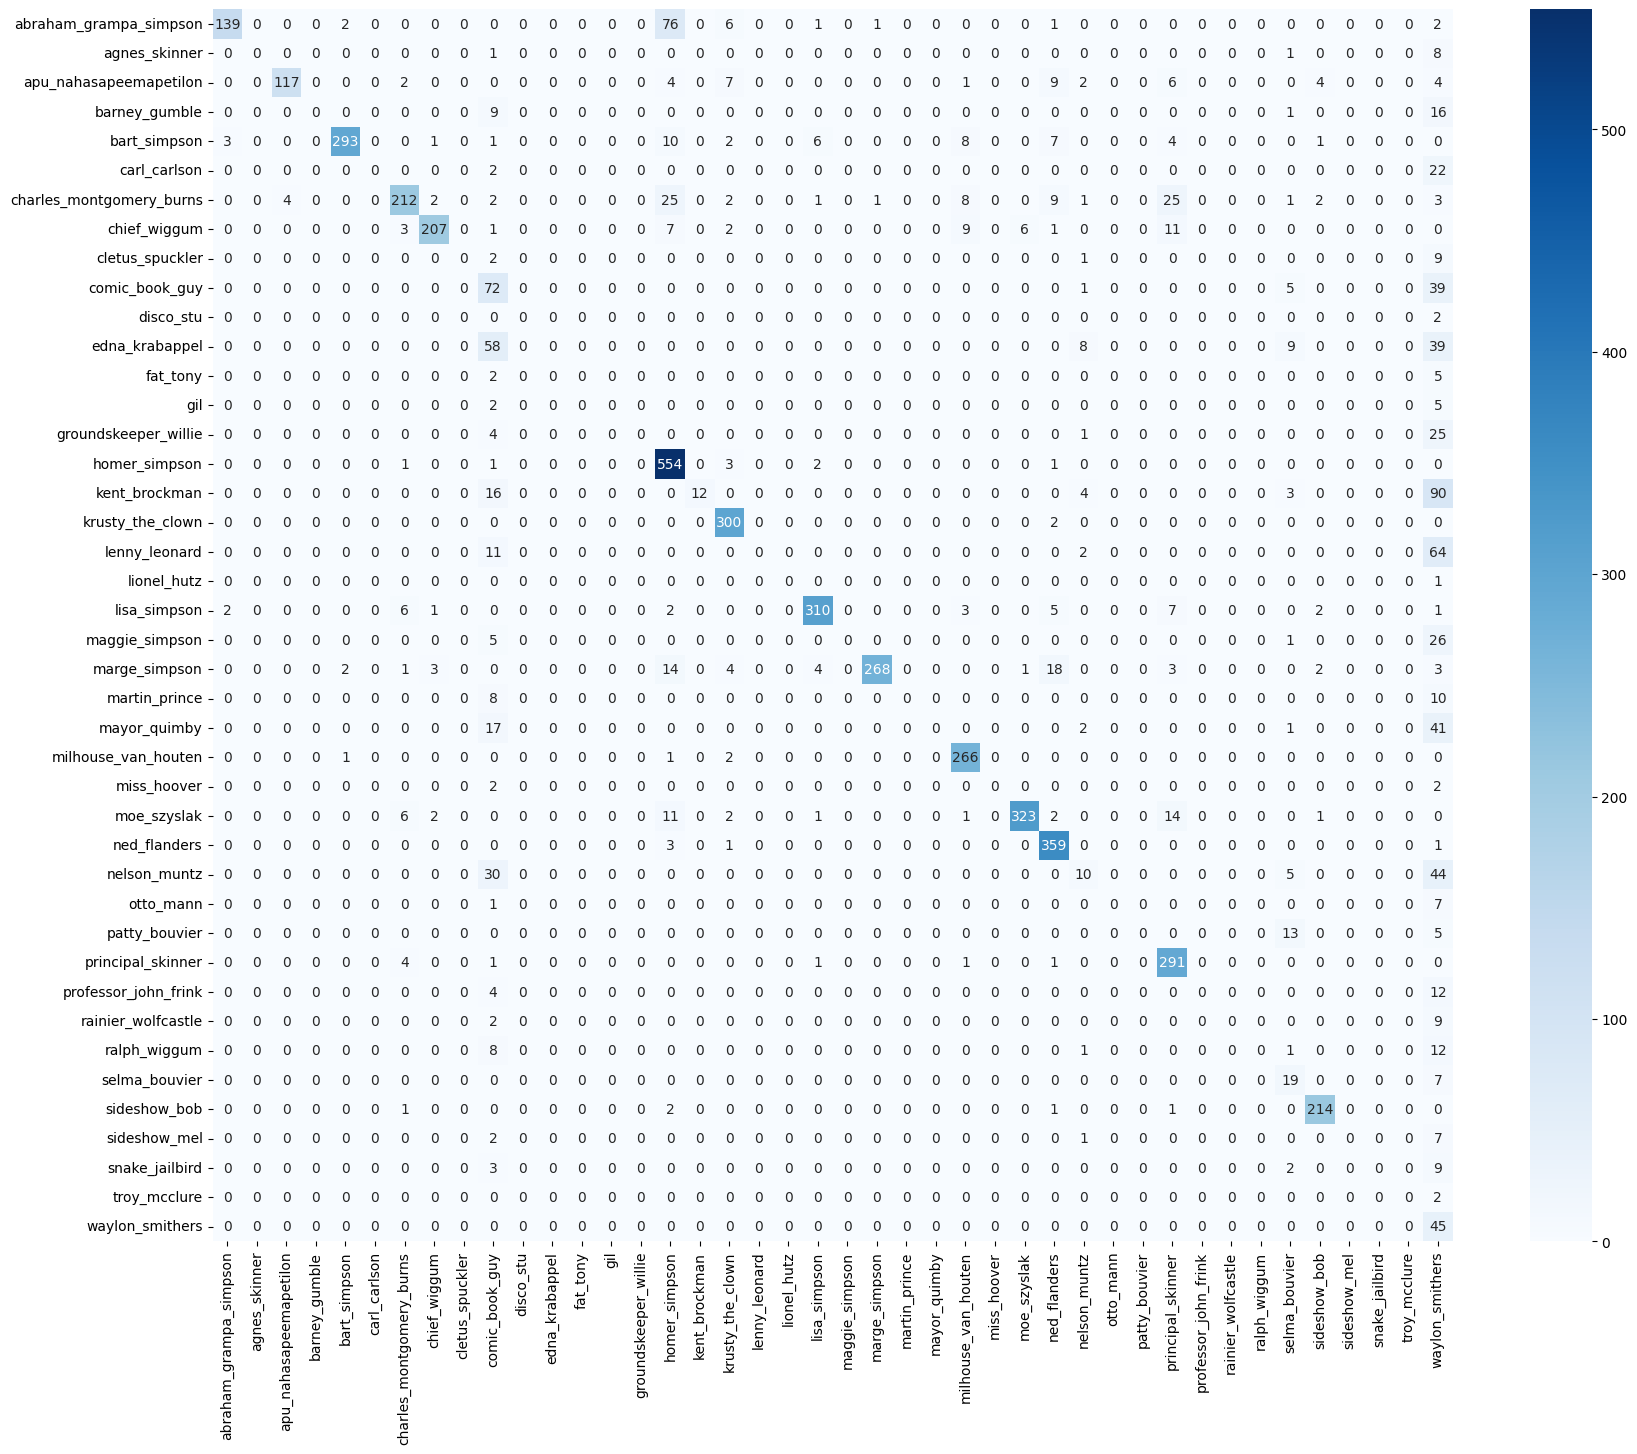

In [ ]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_VGG19(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

Матрица для ResNet

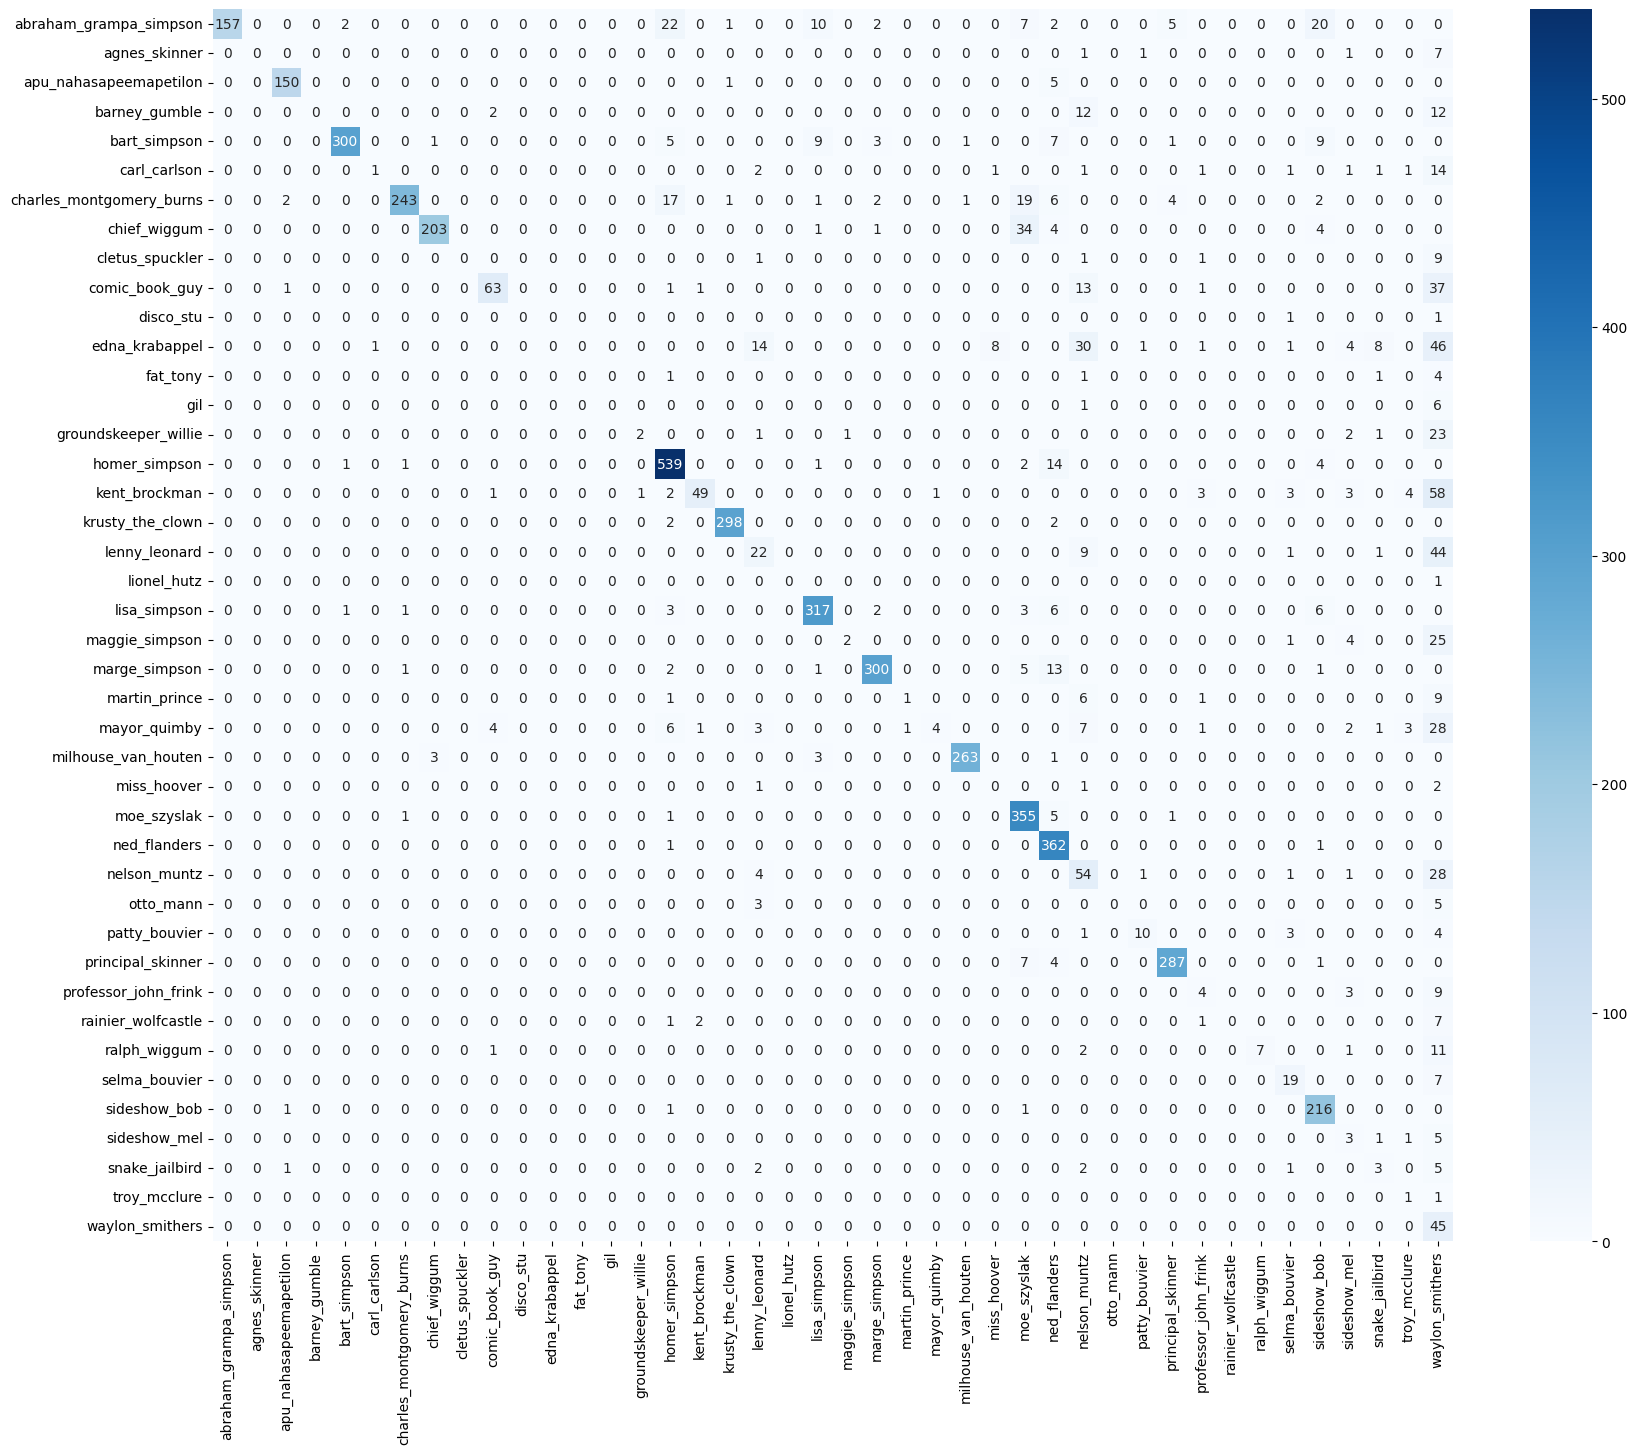

In [ ]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_ResNet(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

Глядя на матрицы ошибок, можно сказать, что модель имеет недостаточно высокую точность из-за того, что некоторые классы не определяет вообще. Значит аугментация и балансировка классов не помогли, попробуем выполнить RandomOverSampling

####OverSamlping

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import WeightedRandomSampler
# Получим метки для train файлов
train_labels = [path.parent.name for path in train_files]

# Применим oversampling
ros = RandomOverSampler()
train_files_resampled, train_labels_resampled = ros.fit_resample(
    np.array(train_files).reshape(-1, 1), train_labels
)

# Преобразуем обратно в список путей
train_files_resampled = [Path(f[0]) for f in train_files_resampled]



In [ ]:
train_labels = [path.parent.name for path in train_files_resampled]
train_counter = Counter(train_labels)

print("Количество объектов в каждом классе тренировочной выборки:")
for class_name, count in train_counter.items():
    print(f"Класс {class_name}, количество {count}, доля {count * 100 / len(train_files_resampled):.2f}%")



Количество объектов в каждом классе тренировочной выборки:
Класс lisa_simpson, количество 1684, доля 2.38%
Класс charles_montgomery_burns, количество 1684, доля 2.38%
Класс bart_simpson, количество 1684, доля 2.38%
Класс mayor_quimby, количество 1684, доля 2.38%
Класс abraham_grampa_simpson, количество 1684, доля 2.38%
Класс chief_wiggum, количество 1684, доля 2.38%
Класс ned_flanders, количество 1684, доля 2.38%
Класс sideshow_bob, количество 1684, доля 2.38%
Класс principal_skinner, количество 1684, доля 2.38%
Класс carl_carlson, количество 1684, доля 2.38%
Класс moe_szyslak, количество 1684, доля 2.38%
Класс homer_simpson, количество 1684, доля 2.38%
Класс milhouse_van_houten, количество 1684, доля 2.38%
Класс krusty_the_clown, количество 1684, доля 2.38%
Класс ralph_wiggum, количество 1684, доля 2.38%
Класс disco_stu, количество 1684, доля 2.38%
Класс nelson_muntz, количество 1684, доля 2.38%
Класс agnes_skinner, количество 1684, доля 2.38%
Класс lenny_leonard, количество 1684, дол

In [ ]:
train_dataset = SimpsonsDataset(train_files_resampled, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Теперь все классы выровнены, попробуем использовать модель ResNet, которая показала лучшее соотношение метрики и времени в прошлый раз

In [ ]:
model_ResNet_2 = models.resnet18(weights=weights_ResNet)
model_ResNet_2.fc = nn.Linear(512, len(class_names))

In [ ]:
optimizer = torch.optim.Adam(model_ResNet_2.parameters(), lr=1e-4)
model_ResNet_2, train_time = train(model_ResNet_2, train_loader, val_loader, loss_fn, optimizer, 15)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.0563232827911766
Точность на данных 0.6874283530760412
Эпоха 2
Функция потерь (кросс-энтропия) на данных 0.8813244688367932
Точность на данных 0.7542988154375239
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.7800698170672925
Точность на данных 0.7781811234237677
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.8455577456432687
Точность на данных 0.7932747420710737
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.6559764390009757
Точность на данных 0.8316774933129537
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.580285590296293
Точность на данных 0.8612915552158961
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.5214218583694964
Точность на данных 0.8664501337409247
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.7710231054658655
Точность на данных 0.8165838746656476
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.7113299886281919
Точность на данных 0.8221245701184563
Эпоха 10
Функция потерь (кросс-энтропи

In [ ]:
RESNET2 = MODEL_PATH / "resnet_model_2.pth"
torch.save(obj=model_ResNet_2.state_dict(),
           f=RESNET2)


In [ ]:
accuracy_ResNet_2 = round(evaluate(model_ResNet_2, val_loader, loss_fn)[1],2)
ResNet_2_results = {'model': 'ResNet oversampling', 'accuracy': {accuracy_ResNet_2}, 'time': '7964'}
results.loc[len(results)] = ResNet_2_results

Функция потерь (кросс-энтропия) на данных 0.5150589135836008
Точность на данных 0.8790599923576614


In [ ]:
print(results)

                 model accuracy                 time
0              AlexNet   {0.78}                 1752
1                VGG19   {0.76}                 4994
2               ResNet   {0.82}                 1841
3  ResNet oversampling   {0.88}  {7964.183574676514}


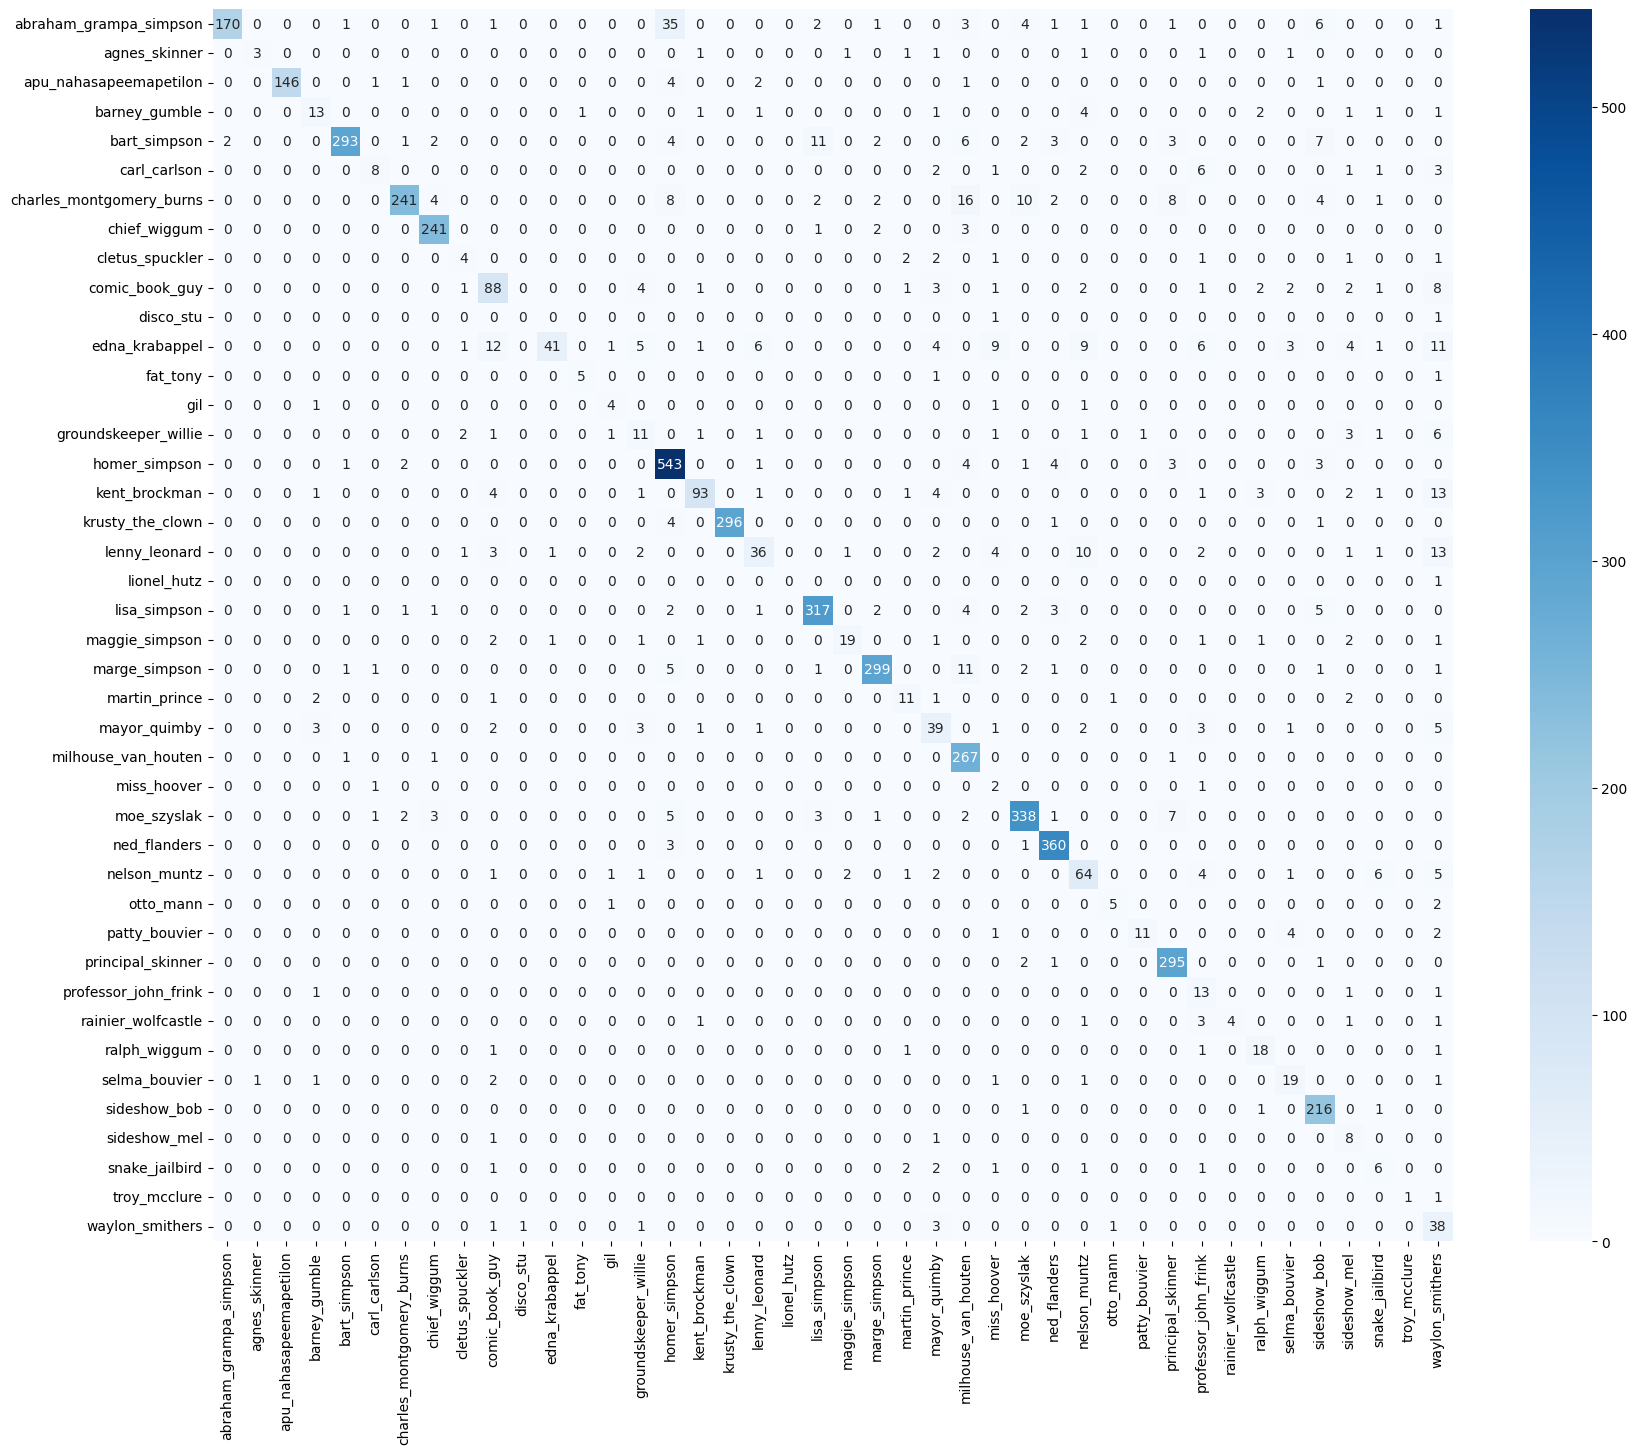

In [ ]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_ResNet_2(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

Точность значительно выросла, "пустых" классов стало меньше, но они по-прежнему остались, возможно это связано с тем, что в валидационной выборке также мало объектов в миноритарных классах. <br><br> Если говорить про ошибки, чаще всего модель путает абрахама и гомера симпсона, барта и лизу симпсон, бёрнса с милхаузом и мо, также есть два персонажа, у которых много пересечений с другими относительно правильных ответов - это эдна крабапл и смиттерс.

##Функция прогноза по картинке URL

In [ ]:
import requests
from io import BytesIO
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [ ]:
def predict_url(url, model):

    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    response = requests.get(url, verify=False)
    image = Image.open(BytesIO(response.content))
    image_transformed = transform(image)
    plt.imshow(image_transformed.permute(1, 2, 0))
    model.eval()
    with torch.inference_mode():
        model_output = model(image_transformed.reshape((1, 3, 224, 224)).to(device))
    class_label = torch.argmax(model_output, dim=1)
    predicted_class_label = class_names[class_label]
    print(predicted_class_label)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

charles_montgomery_burns


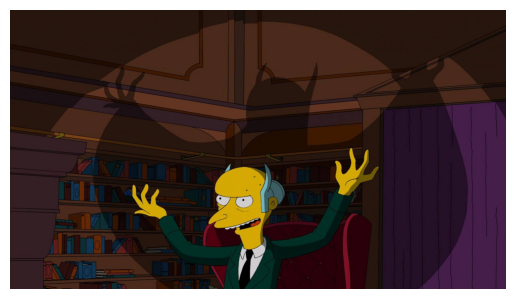

In [ ]:
url = 'https://w.forfun.com/fetch/8c/8ce17ba82fdbfdefe26eaad3754f44ea.jpeg'
predict_url(url, model_ResNet_3)

##Функция вывода и прогноза 25 картинок из теста

In [ ]:
def visualization(dataset, model, class_names):

    dataloader = DataLoader(dataset, batch_size=25, shuffle=True)

    images = next(iter(dataloader))

    model.eval()
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    images = images.cpu()
    preds = preds.cpu()

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()
    for img, pred, ax in zip(images, preds, axes):
        img = img.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Денормализация
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(class_names[pred])
        ax.axis('off')

    plt.tight_layout()
    plt.show()


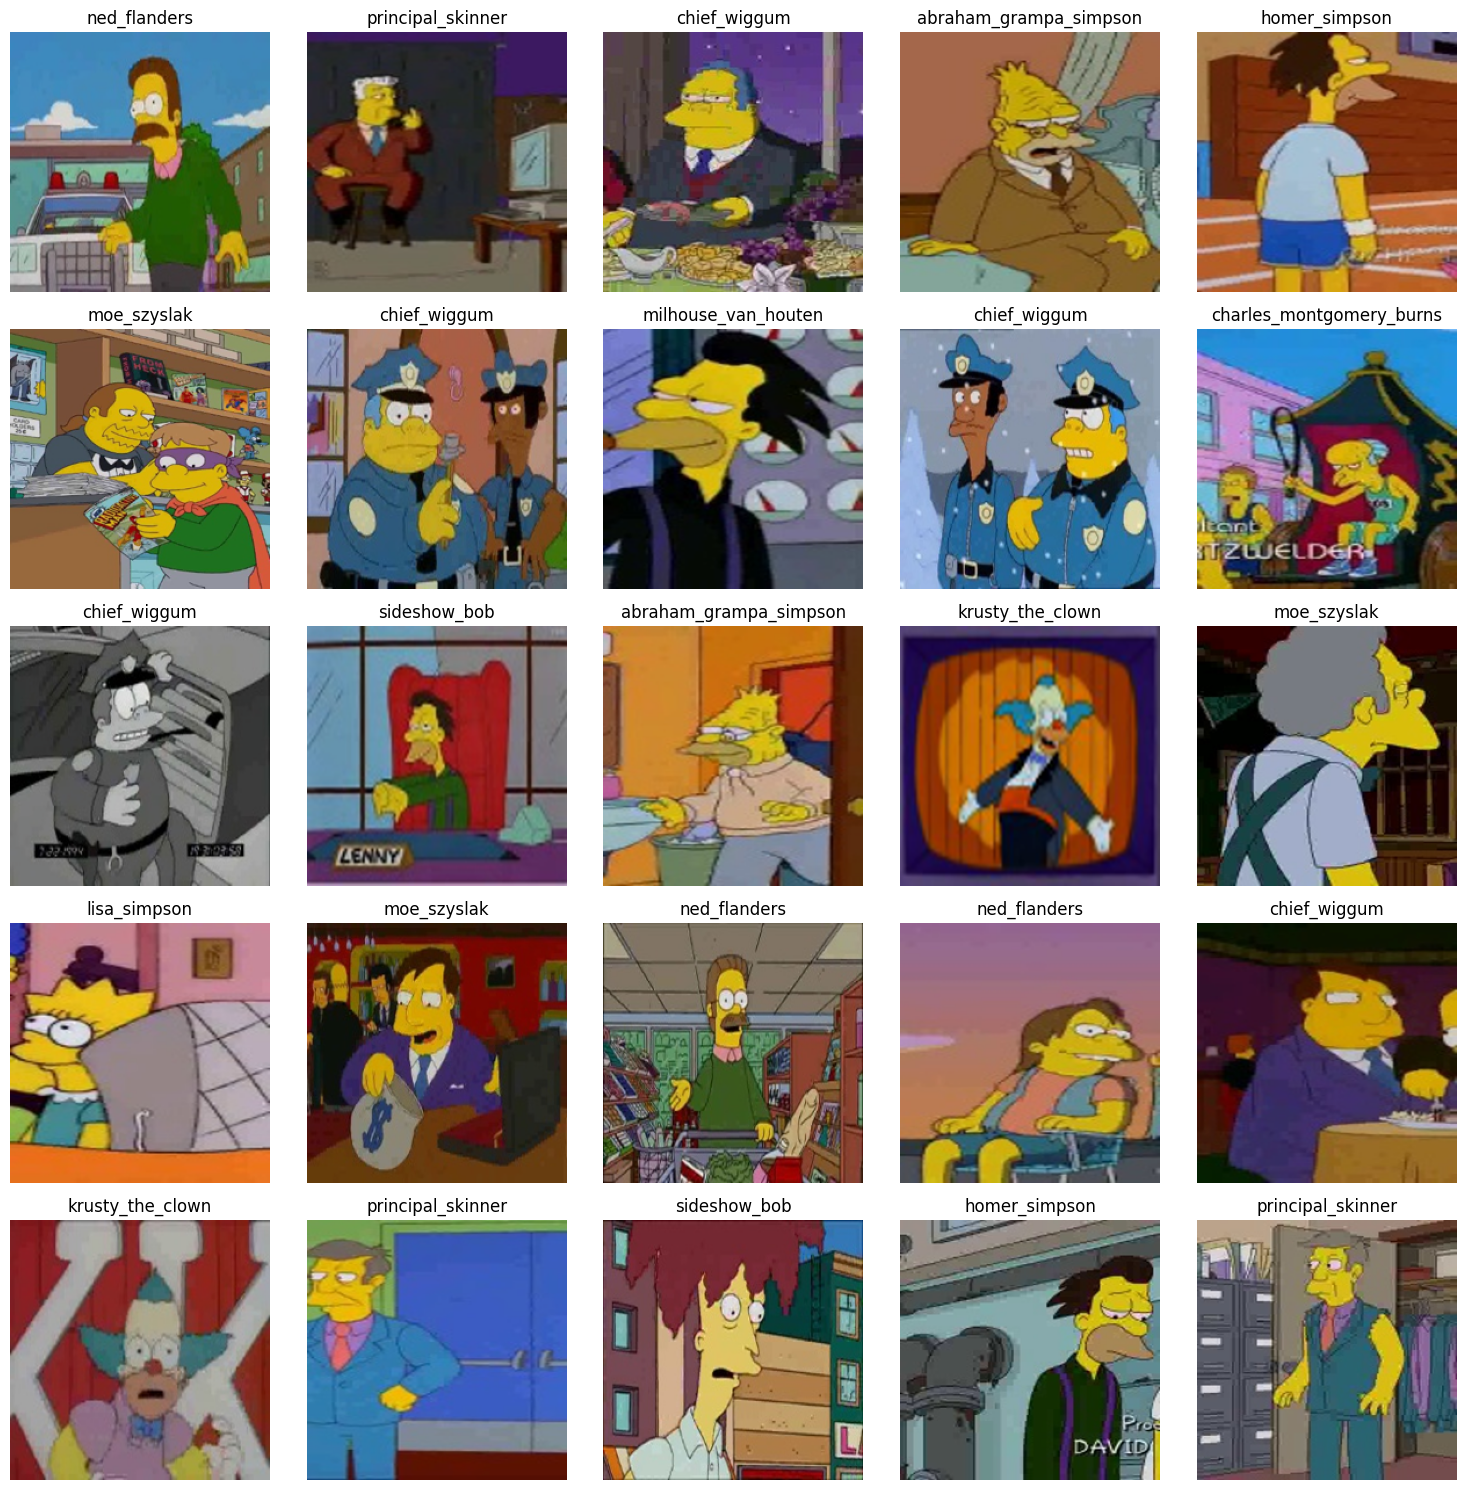

In [ ]:
visualization(test_dataset, model_ResNet_2, class_names)

На случайных 25 изображениях модель ошиблась 8 раз, что довольно много.

Попробуем обогатить тренировочную выборку другим способом - привести количество объектов к числу объектов максимального класса, скопировав изображения с применением разнообразной аугментации.

####Обогащение выборки разнообразной аугментацией

In [ ]:
from collections import Counter
import shutil

In [ ]:
# Определим трансформации для аугментации
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))
])

# Определим папку с изображениями и читаем пути к ним
train_files = list(Path("/kaggle/working/train/simpsons_dataset").rglob("*.jpg"))

# Получим метки классов и количество изображений в каждом классе
train_labels = [path.parent.name for path in train_files]
counter = Counter(train_labels)
max_count = 1684

# Создадим папку для увеличенных данных
augmented_data_dir = Path("/kaggle/working/augmented_data")
augmented_data_dir.mkdir(exist_ok=True)

# Создадим подкатегории для каждого класса
for label in counter.keys():
    (augmented_data_dir / label).mkdir(exist_ok=True)

total_augmented = 0
# Копируем оригинальные изображения и создаем дополнительные для классов с меньшим количеством изображений
for file in train_files:
    label = file.parent.name
    count = counter[label]
    dest_dir = augmented_data_dir / label
    shutil.copy(file, dest_dir / file.name)

    if count < max_count:
        # Создаем дополнительные изображения для меньшинственных классов
        additional_files_needed = max_count - count
        total_augmented += additional_files_needed
        for i in range(additional_files_needed):
            new_file = dest_dir / f"{file.stem}_aug_{i}.jpg"
            original_image = Image.open(file)
            augmented_image = transform(original_image)
            augmented_image = augmented_image.convert("RGB")
            augmented_image.save(new_file, "JPEG", quality=85)  # Сохраняем с качеством 85
    counter[label] = max_count  # Обновим количество изображений для класса до максимального значения

print(f"Total augmented images created: {total_augmented}")


Total augmented images created: 50357


In [ ]:
# Обновим список файлов и метки
train_files = list(augmented_data_dir.glob('**/*.jpg'))
train_labels = [path.parent.name for path in train_files]

In [ ]:

train_counter = Counter(train_labels)

print("Количество объектов в каждом классе тренировочной выборки:")
for class_name, count in train_counter.items():
    print(f"Класс {class_name}, количество {count}, доля {count * 100 / len(train_files):.2f}%")



Количество объектов в каждом классе тренировочной выборки:
Класс barney_gumble, количество 1684, доля 2.36%
Класс disco_stu, количество 1684, доля 2.36%
Класс sideshow_mel, количество 1684, доля 2.36%
Класс groundskeeper_willie, количество 1684, доля 2.36%
Класс abraham_grampa_simpson, количество 1684, доля 2.36%
Класс lenny_leonard, количество 1684, доля 2.36%
Класс patty_bouvier, количество 1684, доля 2.36%
Класс comic_book_guy, количество 1684, доля 2.36%
Класс lionel_hutz, количество 1684, доля 2.36%
Класс gil, количество 1684, доля 2.36%
Класс lisa_simpson, количество 1684, доля 2.36%
Класс nelson_muntz, количество 1684, доля 2.36%
Класс miss_hoover, количество 1684, доля 2.36%
Класс apu_nahasapeemapetilon, количество 1684, доля 2.36%
Класс carl_carlson, количество 1684, доля 2.36%
Класс moe_szyslak, количество 1684, доля 2.36%
Класс agnes_skinner, количество 1684, доля 2.36%
Класс maggie_simpson, количество 1684, доля 2.36%
Класс principal_skinner, количество 1684, доля 2.36%
Кла

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
weights_ResNet = models.ResNet18_Weights.DEFAULT
model_ResNet_3 = models.resnet18(weights=weights_ResNet)
model_ResNet_3.fc = nn.Linear(512, len(class_names))

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ResNet_3.parameters(), lr=1e-4)
model_ResNet_3, train_time = train(model_ResNet_3, train_loader, val_loader, loss_fn, optimizer, 15)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 0.07803306578756658
Точность на данных 0.9801299197554452
Эпоха 2
Функция потерь (кросс-энтропия) на данных 0.12492157112620678
Точность на данных 0.9661826518914788
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.06314745692747592
Точность на данных 0.9818494459304548
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.09525854709615332
Точность на данных 0.9724875811998471
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.09020668411550078
Точность на данных 0.9764998089415361
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.019704911112463662
Точность на данных 0.9935040122277417
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.14695559823767937
Точность на данных 0.9594956056553305
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.05503897781532707
Точность на данных 0.9850974398165838
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.008659009296522887
Точность на данных 0.9984715322888804
Эпоха 10
Функция потерь (к

In [ ]:
RESNET3 = MODEL_PATH / "resnet_model_3.pth"
torch.save(obj=model_ResNet_3.state_dict(),
           f=RESNET3)


In [ ]:
accuracy_ResNet_3 = round(evaluate(model_ResNet_3, val_loader, loss_fn)[1],2)
ResNet_3_results = {'model': 'ResNet 3.0', 'accuracy': {accuracy_ResNet_3}, 'time': {train_time}}


Функция потерь (кросс-энтропия) на данных 0.035398435764512355
Точность на данных 0.9904470768055025


In [ ]:
Result_AlexNet = {'model': 'AlexNet', 'accuracy': {0.78}, 'time': {1752}}
Result_VGG19 = {'model': 'VGG19', 'accuracy': {0.76}, 'time': {4994}}
Result_ResNet = {'model': 'ResNet', 'accuracy': {0.82}, 'time': {1841}}
Result_ResNet2 = {'model': 'ResNet oversamling', 'accuracy': {0.88}, 'time': {7964}}
results.loc[len(results)] = Result_AlexNet
results.loc[len(results)] = Result_VGG19
results.loc[len(results)] = Result_ResNet
results.loc[len(results)] = Result_ResNet2

In [ ]:
results.loc[len(results)] = ResNet_3_results

In [ ]:
print(results)

                model accuracy                 time
0             AlexNet   {0.78}               {1752}
1               VGG19   {0.76}               {4994}
2              ResNet   {0.82}               {1841}
3  ResNet oversamling   {0.88}               {7964}
4          ResNet 3.0   {0.99}  {3716.242778301239}


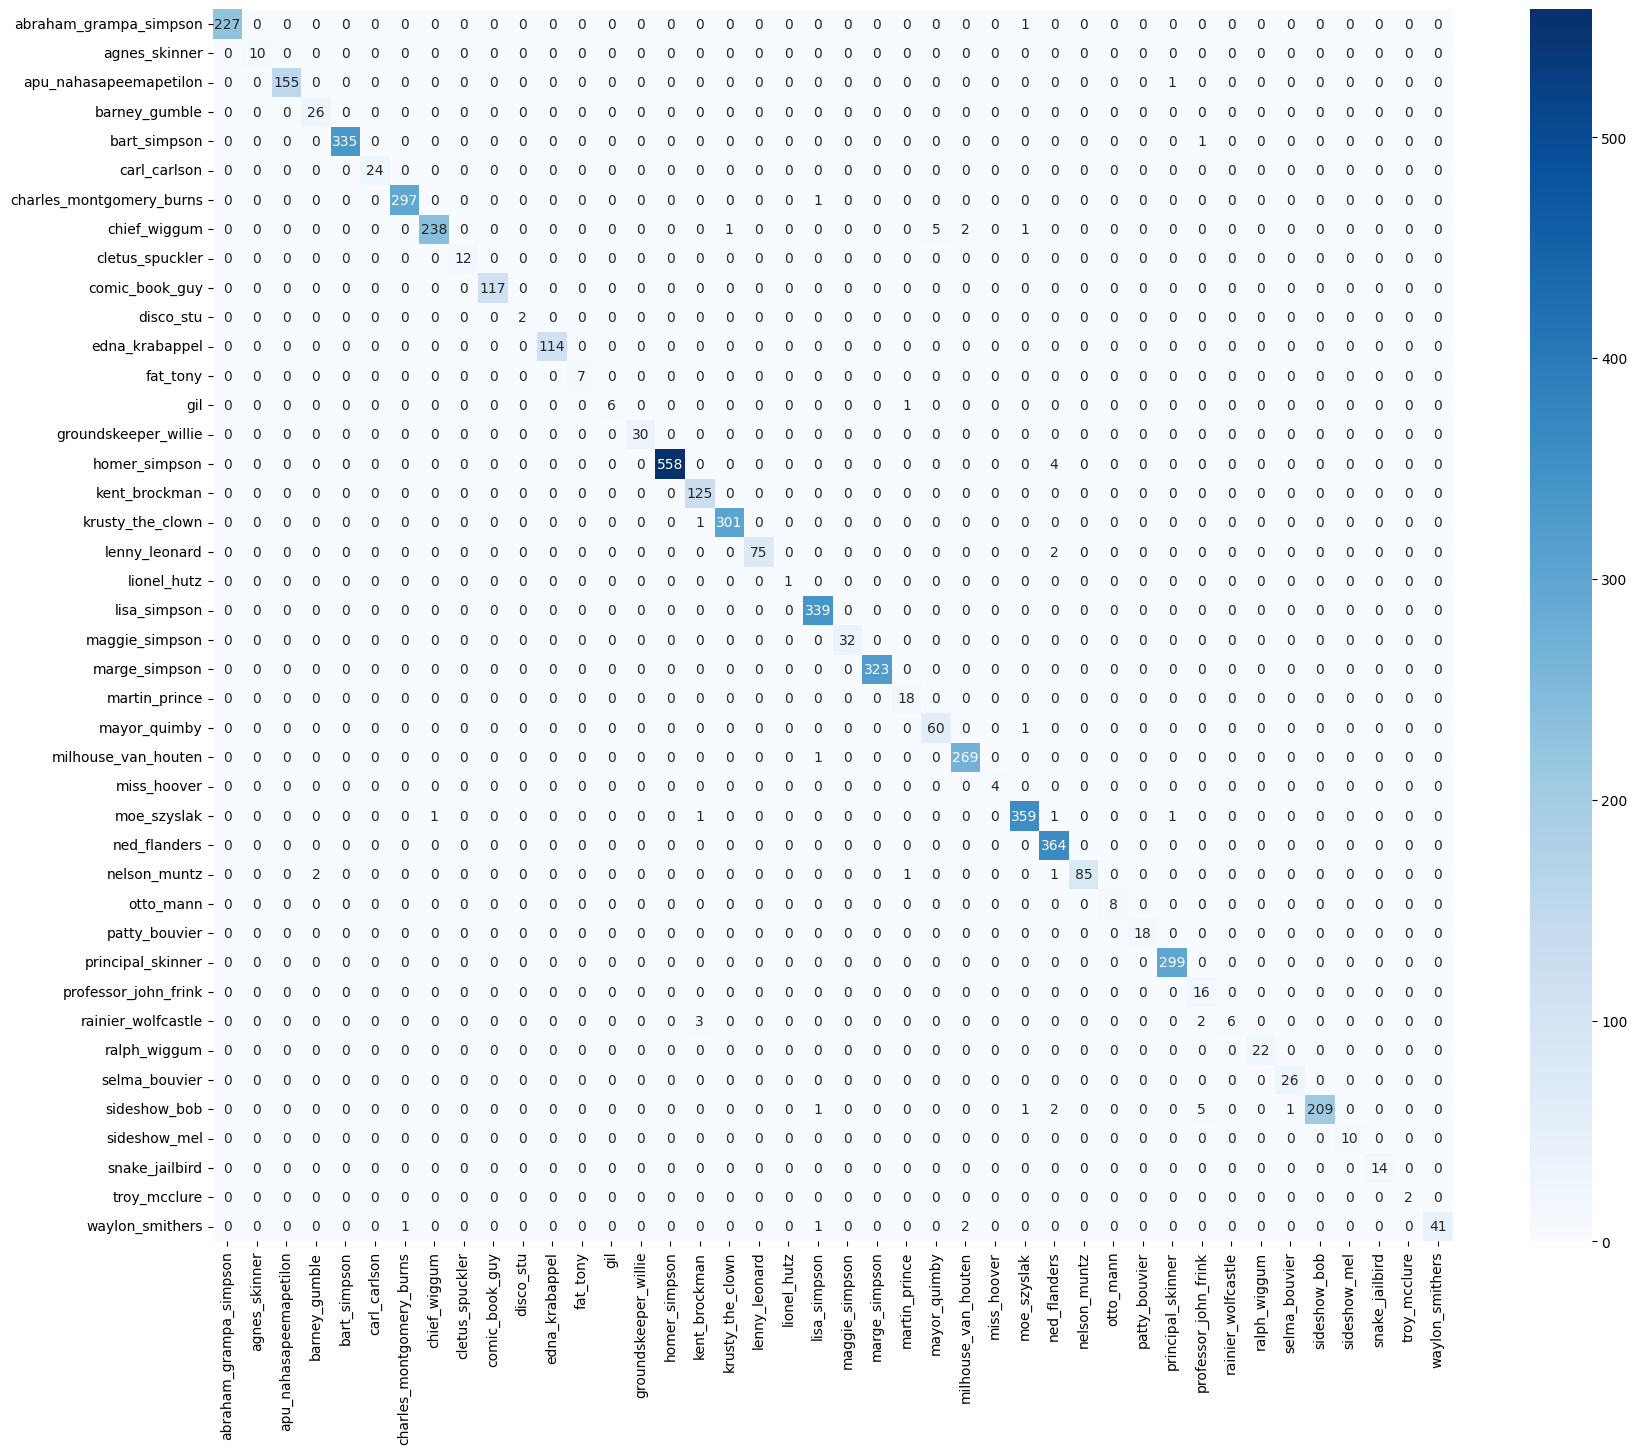

In [ ]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_ResNet_3(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

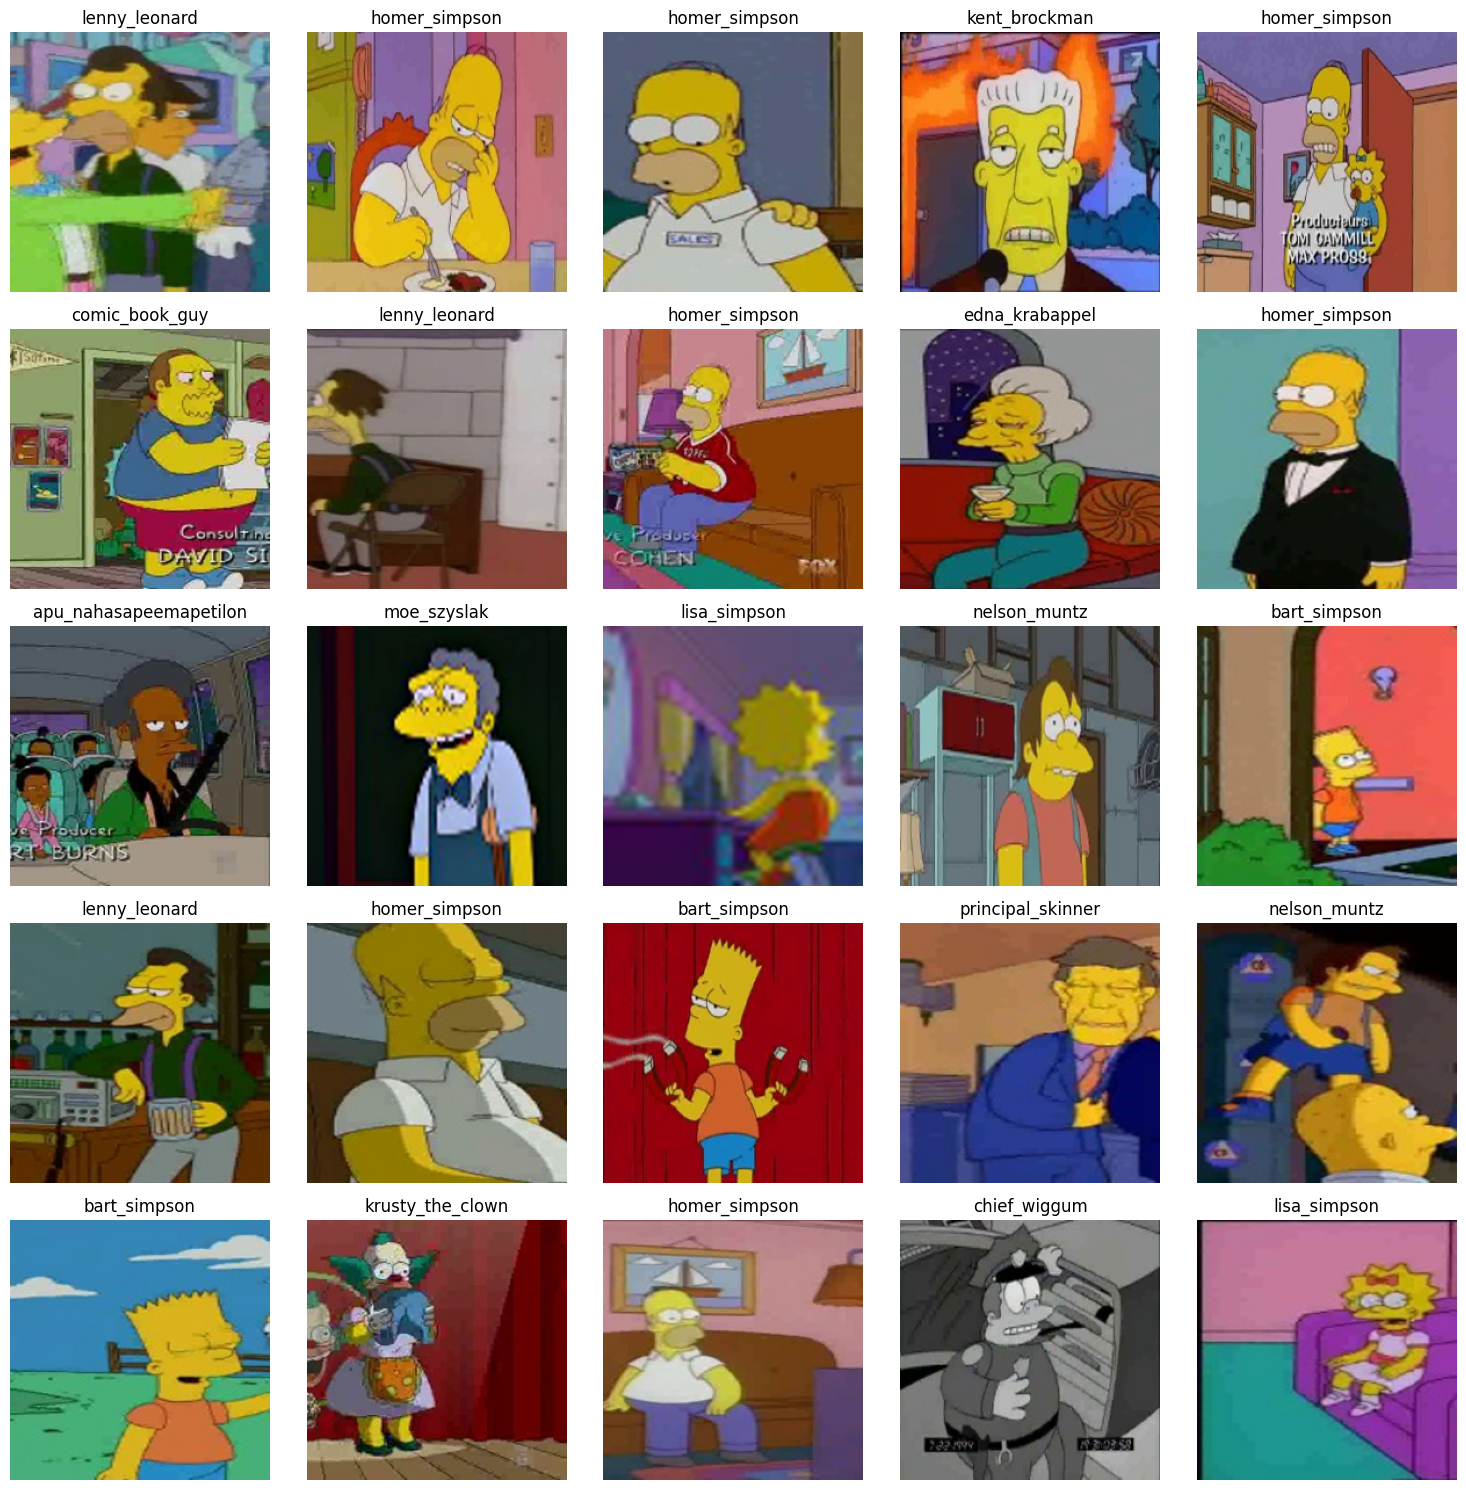

In [ ]:
visualization(test_dataset, model_ResNet_3, class_names)

В результате лучшим способом достичь высшего качество оказалось обогащение выборки с помощью создания объектов с применением аугментации до тех пор, пока число объектов в каждом классе не достигнет максимального класса. Такой подход позволил достичь метрики качества accuracy 99% на валидации, проверка вывода случайных 25 объектов на тесте определила безошибочно.